# AAPL Trading Strategy based on Random Forest and Breakout System

In [797]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px

## Data Pre-processing

In [798]:
AAPL = pd.read_excel("./data/AAPL_EQUITY.xlsx")
SPESG = pd.read_excel(('./data/SPESG_Index_5Y.xlsx')).dropna()

# Take SPESG and AAPL and combine them into one data frame: df['Date', 'SPESG', 'AAPL_Px', 'AAPL_Volume', 'AAPL_SMAVG(15)']
df = pd.merge(AAPL, SPESG, on='Date', how='inner')
new_columns = {'Last Px_x' : 'AAPL_Px', 'Volume': 'AAPL_Volume(M)', 'SMAVG(15)' : 'AAPL_SMAVG15(M)', 'Last Px_y': 'SPESG'}
df.rename(columns=new_columns, inplace=True)
df = df.dropna()
# Strip M and convert these columns from object into float64
df['AAPL_Volume(M)'] = df['AAPL_Volume(M)'].str.strip('M').astype('float64')
df['AAPL_SMAVG15(M)'] = df['AAPL_SMAVG15(M)'].str.strip('M').astype('float64')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.strftime('%A')
df

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day
0,2024-04-26,169.520,25.946,56.944,453.52,2024,2,4,Friday
1,2024-04-25,169.890,50.558,58.021,446.47,2024,2,4,Thursday
2,2024-04-24,169.020,48.252,58.231,447.28,2024,2,4,Wednesday
3,2024-04-23,166.900,49.538,58.193,446.95,2024,2,4,Tuesday
4,2024-04-22,165.840,48.116,58.179,441.80,2024,2,4,Monday
...,...,...,...,...,...,...,...,...,...
1255,2019-05-02,52.287,127.985,108.815,242.00,2019,2,5,Thursday
1256,2019-05-01,52.630,259.309,106.068,242.55,2019,2,5,Wednesday
1257,2019-04-30,50.167,186.140,98.319,244.34,2019,2,4,Tuesday
1258,2019-04-29,51.153,88.819,92.811,243.59,2019,2,4,Monday


## Calculate returns

In [799]:
ret_period = [1, 5, 10, 30, 60, 120, 250]
for p in ret_period:
    df[f'AAPL_Px_ret{p}'] = ((df['AAPL_Px'] - df['AAPL_Px'].shift(-p)) / df['AAPL_Px'].shift(-p)).round(4)

df['AAPL_ret_f1'] = df['AAPL_Px_ret1'].shift(-1)

# Calculate the 100-day moving average
df['AAPL_Px_100MA'] = df['AAPL_Px'].shift(-100).rolling(window=100).mean()
df['AAPL_Px_50MA'] = df['AAPL_Px'].shift(-50).rolling(window=50).mean()
df['AAPL_Px_10MA'] = df['AAPL_Px'].shift(-10).rolling(window=10).mean()

weekday_dummies = pd.get_dummies(df['Day']).astype(int)
df = pd.concat([df, weekday_dummies], axis=1)

In [800]:
df.head()

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day,AAPL_Px_ret1,...,AAPL_Px_ret250,AAPL_ret_f1,AAPL_Px_100MA,AAPL_Px_50MA,AAPL_Px_10MA,Friday,Monday,Thursday,Tuesday,Wednesday
0,2024-04-26,169.52,25.946,56.944,453.52,2024,2,4,Friday,-0.0022,...,-0.0009,0.0051,NaN,NaN,NaN,1,0,0,0,0
1,2024-04-25,169.89,50.558,58.021,446.47,2024,2,4,Thursday,0.0051,...,0.0088,0.0127,NaN,NaN,NaN,0,0,1,0,0
2,2024-04-24,169.02,48.252,58.231,447.28,2024,2,4,Wednesday,0.0127,...,0.0321,0.0064,NaN,NaN,NaN,0,0,0,0,1
3,2024-04-23,166.90,49.538,58.193,446.95,2024,2,4,Tuesday,0.0064,...,0.0191,0.0051,NaN,NaN,NaN,0,0,0,1,0
4,2024-04-22,165.84,48.116,58.179,441.80,2024,2,4,Monday,0.0051,...,0.0031,-0.0122,NaN,NaN,NaN,0,1,0,0,0


## Correlation Test

In [801]:
# Test correlations
from scipy.stats import pearsonr

data1 = df['AAPL_Px'].dropna()
data1.drop(data1.tail(1).index, inplace=True)

data2 = df['AAPL_Px_ret1'].dropna()

data3 = df['SPESG'].dropna().shift(-1).dropna()

corr_px, _ = pearsonr(data1,data3)
print('Px-SPESG correlation: %.3f' % corr_px)

corr_ret, _ = pearsonr(data2,data3)
print('Ret-SPESG correlation: %.3f' % corr_ret)

Px-SPESG correlation: 0.935
Ret-SPESG correlation: -0.067


In [802]:
import pandas as pd
from scipy.stats import pearsonr

# Drop missing values in both series
data2 = df['AAPL_Px_ret250'].dropna()
data3 = df['SPESG'].dropna()

# Shift the SPESG data
data3 = data3.shift(-1)

# Align the series
aligned_data = pd.concat([data2, data3], axis=1).dropna()

# Extract the aligned series
aligned_data2 = aligned_data['AAPL_Px_ret250']
aligned_data3 = aligned_data['SPESG']

# Check the lengths to ensure they are equal
print(len(aligned_data2), len(aligned_data3))

# Calculate the correlation
corr_ret, _ = pearsonr(aligned_data2, aligned_data3)
print('Ret-SPESG correlation: %.3f' % corr_ret)


1010 1010
Ret-SPESG correlation: -0.485


## Data splitting
Temoral Train/test split

In [803]:
df.sort_values(by='Date', ascending=True, inplace=True)

split_ts = pd.Timestamp("2021-04-06")
training_set = df[df['Date'] <= split_ts]
holdout_set = df[df['Date'] > split_ts]

## Return Analysis

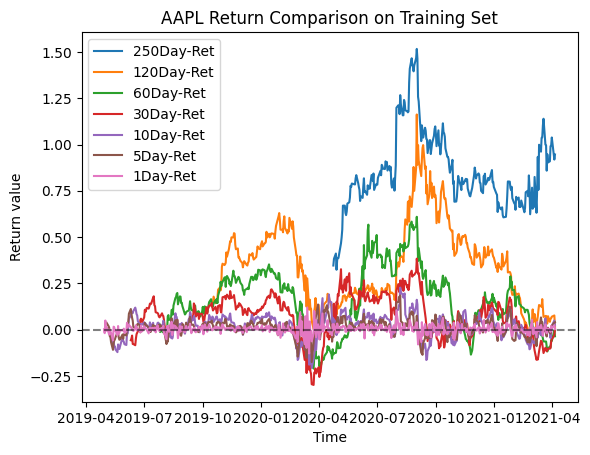

In [804]:
empty_row = training_set.isna().any(axis=1)
plt.plot(training_set['Date'], training_set['AAPL_Px_ret250'], label="250Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret120'], label="120Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret60'], label="60Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret30'], label="30Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret10'], label="10Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret5'], label="5Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret1'], label="1Day-Ret")

plt.axhline(y=0, color="black", alpha=0.5, linestyle='dashed')

plt.legend()
plt.title("AAPL Return Comparison on Training Set")
plt.xlabel("Time")
plt.ylabel("Return value")
plt.show()

**Conclusion** <br>
We can't choose linear regression or other interpolation method to fill the empty ret250 cells, since the 250-Day return seems fluctuating too much. <br>

**Basically, return with any peirod dropped significantly during 2020-4, and longer returns rises up around 2020-08, so the volatility is very large during 2020, which could easily makes the model over-fit.**

# Feature Engineering

In [805]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = training_set.dropna()
df['AAPL_Px_50MA_forward'] = df['AAPL_Px_50MA'].shift(-50)
df = df.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
# y = df['AAPL_ret_f1']
y = df['AAPL_Px_50MA_forward'].dropna()

# Define a list of feature combinations to try
feature_combinations = [
    ['AAPL_Px'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'],
    ['Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ['AAPL_Px_ret1'],
    # .... other combos
]

regressor = RandomForestRegressor()
# Train and evaluate the model for each feature combination
for i, features in enumerate(feature_combinations):
    X_subset = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.4, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    print(f"Feature Combination {i + 1}: {features} - R-squared: {r_squared}")

/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/477558658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AAPL_Px_50MA_forward'] = df['AAPL_Px_50MA'].shift(-50)


Feature Combination 1: ['AAPL_Px'] - R-squared: 0.9429096678213862
Feature Combination 2: ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'] - R-squared: 0.966138193153225
Feature Combination 3: ['Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] - R-squared: 0.9648883817210466
Feature Combination 4: ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] - R-squared: 0.9810398373979317
Feature Combination 5: ['AAPL_Px_ret1'] - R-squared: -0.4575216732378693


Since we didn't find any correlation between different features with forward one-day return, we will use "AAPL_Px_50MA_forward" as the prediction target.

# Modeling

### Random Forest

In [806]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


# We should re-read the df, since we fit the model in feature engineering section 
df = training_set.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Create Random Forest Regressor object
regressor = RandomForestRegressor()

cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')
print(cv_scores.round(3))
print(cv_scores.mean().round(3))

[-0.049  0.209  0.191  0.144  0.125]
0.124


In [807]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Remove outliers using IQR method specifically for AAPL_Px_ret
def remove_outliers_based_on_return(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

# Re-read the df and remove NaNs
df = training_set.dropna()

# Remove outliers based on AAPL_Px_ret
df = remove_outliers_based_on_return(df, 'AAPL_Px_ret1')

# Define features and target
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Feature scaling
scaler = StandardScaler()

# Normalizer
normalizer = Normalizer()

# Lasso model for feature selection
lasso = LassoCV(cv=5)

# Random Forest Regressor
regressor = RandomForestRegressor()

# Create a pipeline with scaling, normalization, Lasso-based feature selection, and Random Forest
pipeline = Pipeline([
    ('scaler', scaler),
    ('normalizer', normalizer),
    # ('feature_selection', SelectFromModel(lasso)),
    ('regressor', regressor)
])

# Define hyperparameters for tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Best estimator
best_regressor = grid_search.best_estimator_

# Cross-validation scores with the best estimator
cv_scores = cross_val_score(best_regressor, X, y, cv=5, scoring='r2')

print("Cross-Validation R2 Scores:", cv_scores.round(3))
print("Mean Cross-Validation R2 Score:", np.mean(cv_scores).round(3))

# Print the optimal hyperparameters
print("Optimal Hyperparameters:", grid_search.best_params_)


Cross-Validation R2 Scores: [-0.094  0.18   0.143  0.053  0.207]
Mean Cross-Validation R2 Score: 0.098
Optimal Hyperparameters: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}


In [808]:
print("Optimal Hyperparameters:", grid_search.best_params_)

Optimal Hyperparameters: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}


# 在Holdout上测试

In [809]:
from sklearn.metrics import mean_squared_error, r2_score

# Preprocess the holdout set
df = holdout_set.dropna()

# Remove outliers based on AAPL_Px_ret in holdout set (optional, depending on your strategy)
df = remove_outliers_based_on_return(df, 'AAPL_Px_ret1')
dates = df['Date']

# Define features and target for holdout set
X_holdout = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y_actual = df['AAPL_ret_f1']

# Apply the same scaling, normalization, and feature selection pipeline to the holdout set
X_holdout_scaled = best_regressor.named_steps['scaler'].transform(X_holdout)
X_holdout_normalized = best_regressor.named_steps['normalizer'].transform(X_holdout_scaled)
# X_holdout_selected = best_regressor.named_steps['feature_selection'].transform(X_holdout_normalized)

# Make predictions using the best model
y_pred = best_regressor.named_steps['regressor'].predict(X_holdout_normalized)

# Evaluate the model
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("Mean Squared Error (MSE) on holdout set:", mse.round(5))
print("R-squared (R²) on holdout set:", r2.round(3))


Mean Squared Error (MSE) on holdout set: 0.00029
R-squared (R²) on holdout set: 0.024


In [810]:
# Create a DataFrame with the predictions
pred_df = pd.DataFrame(X_holdout, columns=X_holdout.columns)
pred_df['Date'] = dates.values
pred_df['AAPL_ret_f1'] = y_actual
pred_df['Predicted_AAPL_ret_f1'] = y_pred

# Save the DataFrame to an Excel file
pred_df.to_excel('holdout_predictions.xlsx', index=False)


# Strategy

In [811]:
# Define the enhanced trading strategy
def enhanced_trading_strategy(row, threshold=0.002):
    if row['Predicted_AAPL_ret_f1'] > threshold:
        return 'Buy'
    elif row['Predicted_AAPL_ret_f1'] < -threshold:
        return 'Sell'
    else:
        return 'Hold'

# Apply the trading strategy to the DataFrame
pred_df['Strategy'] = pred_df.apply(enhanced_trading_strategy, axis=1)

# Calculate daily returns based on the strategy
def calculate_strategy_return(row):
    if row['Strategy'] == 'Buy':
        return row['AAPL_ret_f1']
    elif row['Strategy'] == 'Sell':
        return -row['AAPL_ret_f1']
    else:
        return 0

pred_df['Strategy_Return'] = pred_df.apply(calculate_strategy_return, axis=1)

# Calculate the equity curve
initial_equity = 100000  # Starting with $100,000
pred_df['Equity'] = initial_equity * (1 + pred_df['Strategy_Return']).cumprod()

# Save the DataFrame with the strategy and equity curve to an Excel file
# pred_df.to_excel('holdout_predictions_with_strategy_and_equity_curve.xlsx', index=False)

print("Data with strategy and equity curve saved to holdout_predictions_with_strategy_and_equity_curve.xlsx")

# Display the first few rows of the DataFrame
print(pred_df.head())


Data with strategy and equity curve saved to holdout_predictions_with_strategy_and_equity_curve.xlsx
     AAPL_Px  AAPL_Volume(M)  AAPL_SMAVG15(M)   SPESG  Quarter  Month  \
769  127.900          83.467          101.331  347.49        2      4   
768  130.360          88.845           99.792  348.73        2      4   
767  132.995         106.687           98.807  351.97        2      4   
766  131.240          91.420           92.531  351.58        2      4   
765  134.430          91.267           91.155  352.55        2      4   

     AAPL_Px_ret1  AAPL_Px_ret5  AAPL_Px_ret10  AAPL_Px_ret30  ...  Monday  \
769        0.0134        0.0667         0.0437         0.0162  ...       0   
768        0.0192        0.0672         0.0855         0.0400  ...       0   
767        0.0202        0.0813         0.1029         0.0992  ...       0   
766       -0.0132        0.0424         0.0827         0.0823  ...       1   
765        0.0243        0.0651         0.1074         0.0520  ...    

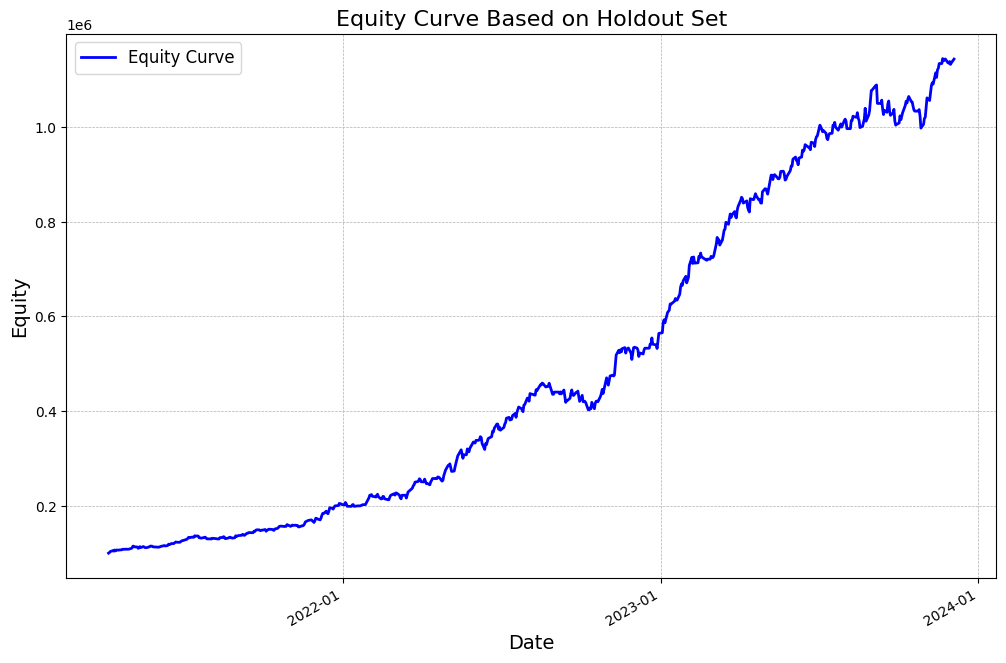

In [823]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(pred_df['Date'], pred_df['Equity'], label='Equity Curve', color='blue', linewidth=2)

# Format the x-axis for dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Equity', fontsize=14)
plt.title('Equity Curve Based on Holdout Set', fontsize=16)

# Add a legend
plt.legend(loc='best', fontsize=12)

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Rotate and align the x labels
plt.gcf().autofmt_xdate()

# Add annotations for significant points (if any)
max_equity = pred_df['Equity'].max()
min_equity = pred_df['Equity'].min()
max_date = pred_df['Date'][pred_df['Equity'].idxmax()]
min_date = pred_df['Date'][pred_df['Equity'].idxmin()]

# Show the plot
plt.show()


## Strategy performance measurement

### Drawdon

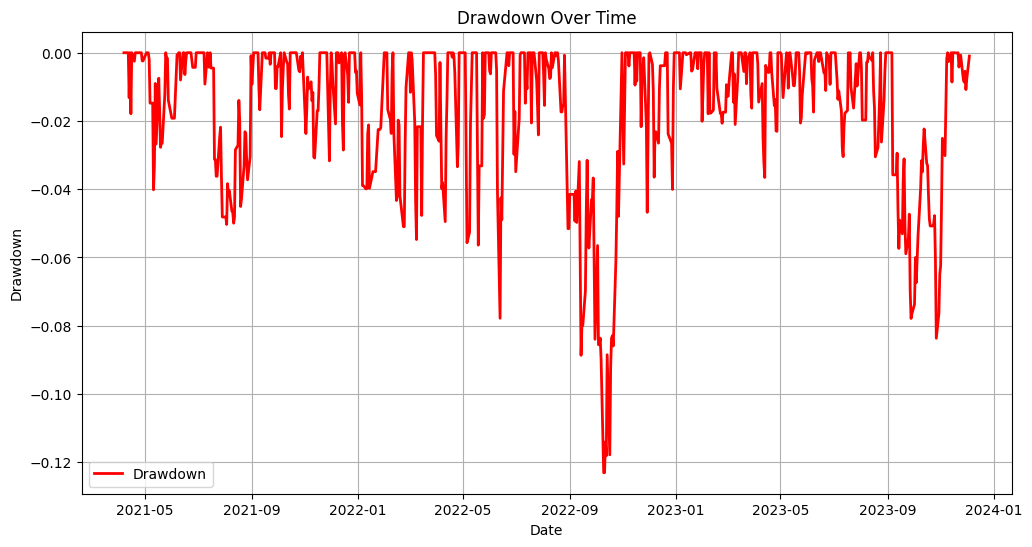

In [825]:
def calculate_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return drawdown

pred_df['Drawdown'] = calculate_drawdown(pred_df['Equity'])

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Drawdown'], label='Drawdown', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdown Over Time')
plt.legend()
plt.grid(True)
plt.show()


### Return vs Holding

In [827]:
def sharpe_ratio_cal(df, period):
    if period == 30:
        risk_free_rate = 0.03 / 12
    else:
        risk_free_rate = (0.03 / 252) * period

    ret_mean = df[f'AAPL_Px_ret{period}'].mean()
    ret_std = df[f'AAPL_Px_ret{period}'].std()
    sharpe_ratio = ((ret_mean - risk_free_rate) / ret_std).round(3)
    print(sharpe_ratio)
    return sharpe_ratio

print("The sharpe ratios are:")
for p in ret_period:
    print(f"{p}-Day Return: Training & Holdout")
    sharpe_ratio_cal(training_set, p)
    sharpe_ratio_cal(holdout_set, p)

The sharpe ratios are:
1-Day Return: Training & Holdout
0.084
0.024
5-Day Return: Training & Holdout
0.205
0.057
10-Day Return: Training & Holdout
0.294
0.083
30-Day Return: Training & Holdout
0.575
0.162
60-Day Return: Training & Holdout
0.871
0.212
120-Day Return: Training & Holdout
1.529
0.399
250-Day Return: Training & Holdout
3.86
0.78


|Sharpe Ratio | Ret1 | Ret5 | Ret10 | Ret30 | Ret120 | Ret250 |
| ------------|------|------|-------|--------|-------|--------|
|Training set |------|------|-------|-|-------|--------|
|Holdout set  |------|- |-------|-|-------|-|

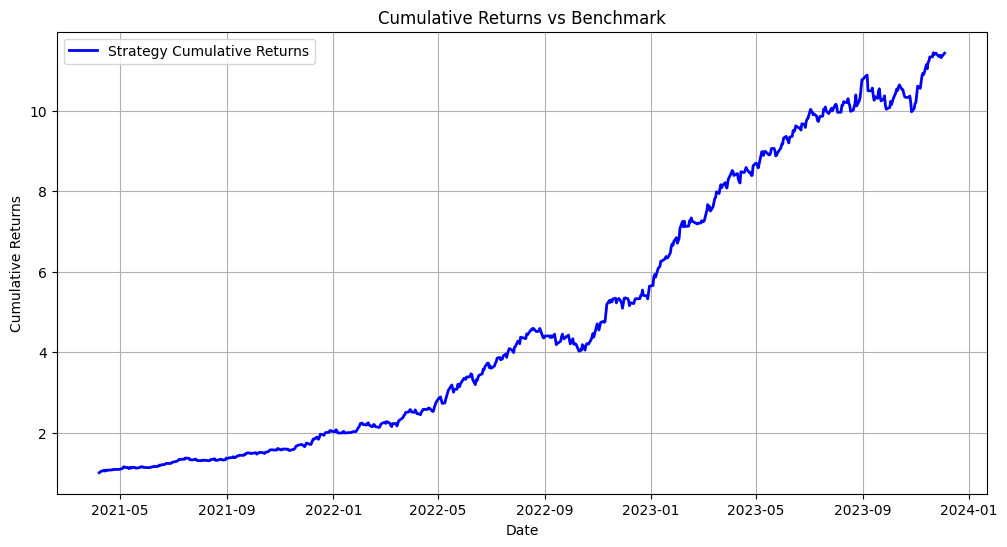

In [828]:
pred_df['Cumulative_Returns'] = (1 + pred_df['Strategy_Return']).cumprod()

# Assuming benchmark returns are available in `benchmark_returns`
# pred_df['Benchmark_Cumulative_Returns'] = (1 + benchmark_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Cumulative_Returns'], label='Strategy Cumulative Returns', color='blue', linewidth=2)
# plt.plot(pred_df['Date'], pred_df['Benchmark_Cumulative_Returns'], label='Benchmark Cumulative Returns', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Benchmark')
plt.legend()
plt.grid(True)
plt.show()


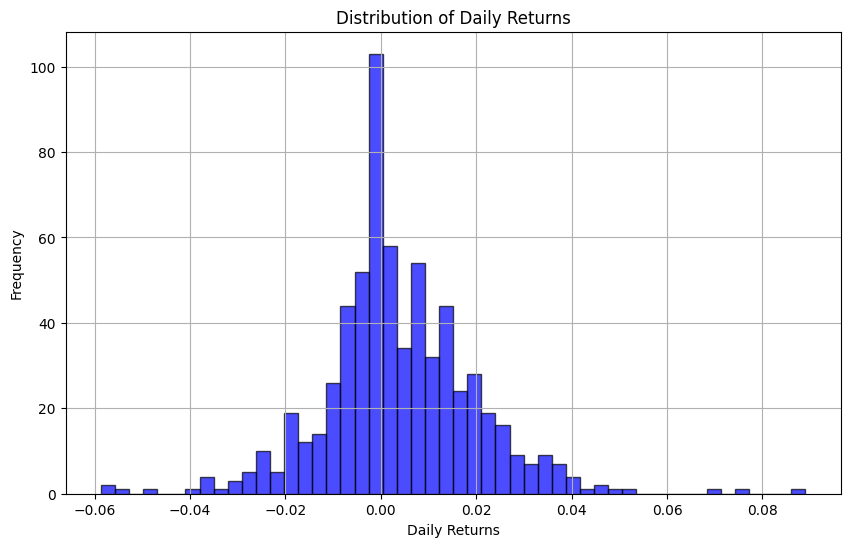

In [829]:
plt.figure(figsize=(10, 6))
plt.hist(pred_df['Strategy_Return'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.grid(True)
plt.show()


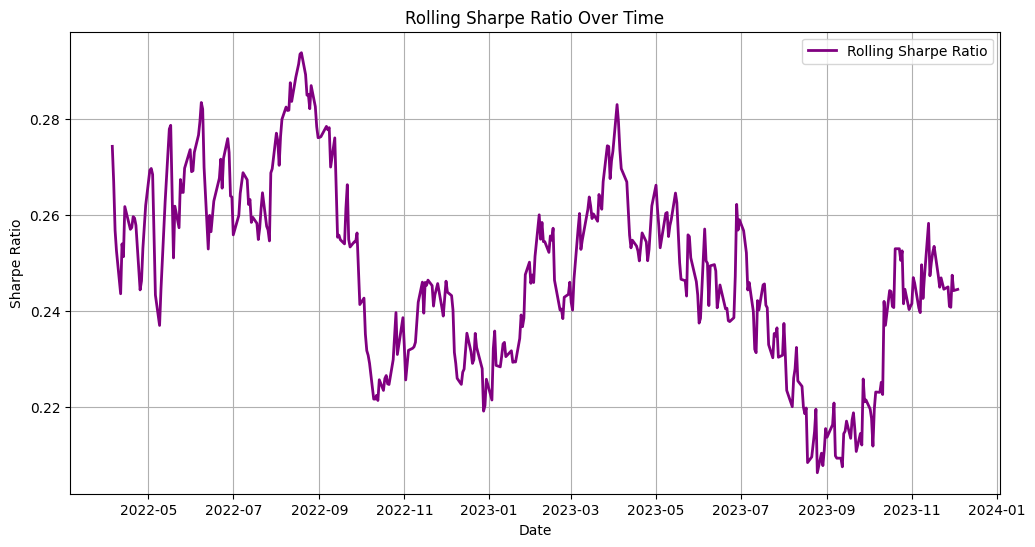

In [830]:
def calculate_rolling_sharpe_ratio(returns, window=252):
    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    rolling_sharpe = rolling_mean / rolling_std
    return rolling_sharpe

pred_df['Rolling_Sharpe'] = calculate_rolling_sharpe_ratio(pred_df['Strategy_Return'])

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Rolling_Sharpe'], label='Rolling Sharpe Ratio', color='purple', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()


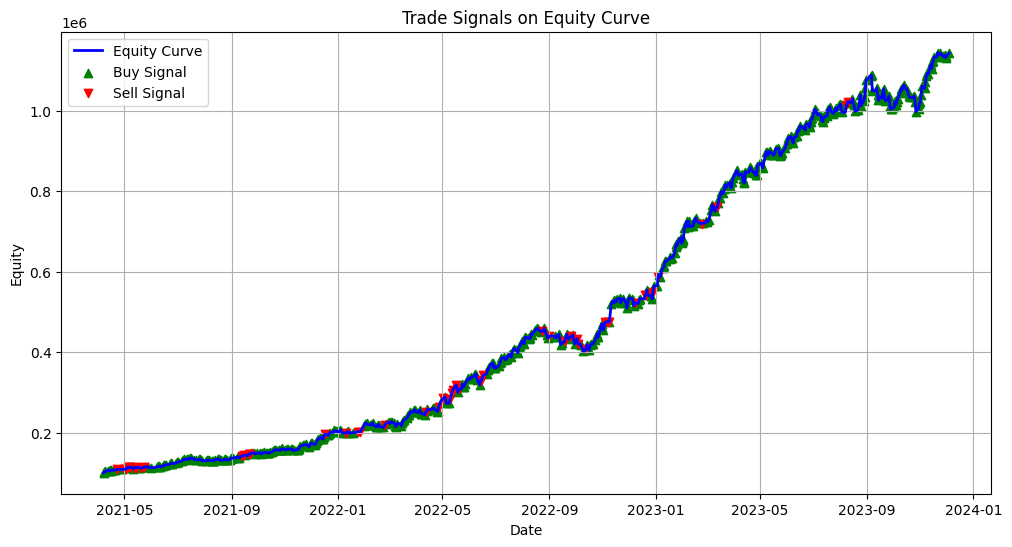

In [831]:
buy_signals = pred_df[pred_df['Strategy'] == 'Buy']
sell_signals = pred_df[pred_df['Strategy'] == 'Sell']

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Equity'], label='Equity Curve', color='blue', linewidth=2)
plt.scatter(buy_signals['Date'], buy_signals['Equity'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals['Date'], sell_signals['Equity'], marker='v', color='red', label='Sell Signal', alpha=1)
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Trade Signals on Equity Curve')
plt.legend()
plt.grid(True)
plt.show()


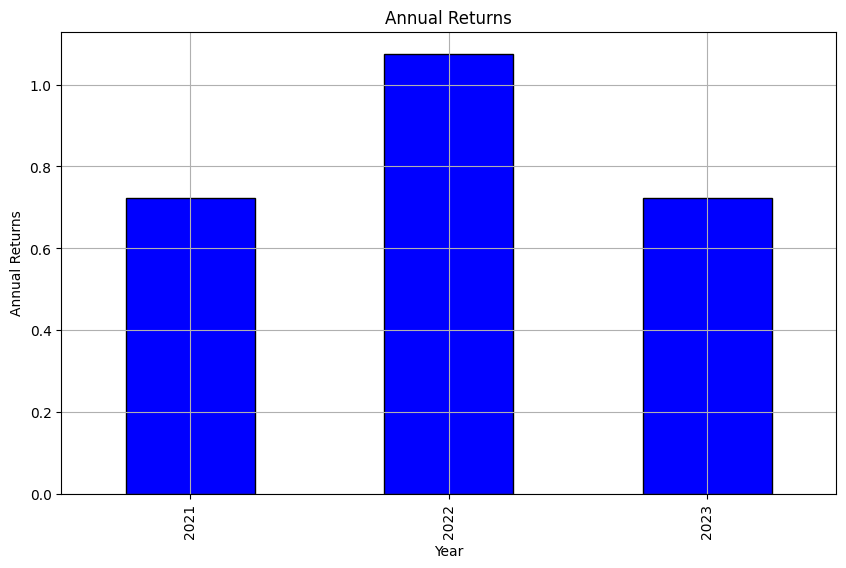

In [832]:
pred_df['Year'] = pred_df['Date'].dt.year
annual_returns = pred_df.groupby('Year')['Strategy_Return'].sum()

plt.figure(figsize=(10, 6))
annual_returns.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Annual Returns')
plt.title('Annual Returns')
plt.grid(True)
plt.show()


In [ ]:
import yfinance as yf
# Get benchmark data (S&P 500)
benchmark = yf.download('^GSPC', start='2019-04-05', end='2024-04-26')
benchmark['Daily_Return'] = benchmark['Adj Close'].pct_change()
benchmark = benchmark.dropna()

# Assuming 'pred_df' contains the strategy data with 'Date' and 'Strategy_Return'
pred_df['Date'] = pd.to_datetime(pred_df['Date'])
benchmark['Date'] = benchmark.index

# Merge the strategy data with benchmark data
merged_df = pd.merge(pred_df, benchmark[['Date', 'Daily_Return']], on='Date', how='inner')
merged_df.rename(columns={'Daily_Return': 'Benchmark_Return'}, inplace=True)

# Calculate Sharpe Ratio
risk_free_rate = 0.01  # Assuming a 1% risk-free rate
excess_returns = merged_df['Strategy_Return'] - risk_free_rate / 252
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

# Calculate Alpha and Beta
cov_matrix = np.cov(merged_df['Strategy_Return'], merged_df['Benchmark_Return'])
beta = cov_matrix[0, 1] / cov_matrix[1, 1]
alpha = np.mean(merged_df['Strategy_Return']) - beta * np.mean(merged_df['Benchmark_Return'])

# Calculate Maximum Drawdown
def calculate_drawdown(equity_curve):
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown

merged_df['Equity'] = (1 + merged_df['Strategy_Return']).cumprod()
drawdown = calculate_drawdown(merged_df['Equity'])
max_drawdown = drawdown.min()

# Print the metrics
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

# Optionally, save the results
results = {
    'Sharpe Ratio': sharpe_ratio,
    'Alpha': alpha,
    'Beta': beta,
    'Maximum Drawdown': max_drawdown
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])
results_df.to_excel('strategy_metrics.xlsx')
